In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats
import pickle
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Visualization

In [2]:
def get_records(ins_name='6x6-72', 
                variant_type='exp',
                budgets=[100, 300, 500], 
                sol_methods=['knn', 'reg', 'naive'], 
                sam_methods=['uniform', 'pmedian', 'pcenter'],
                sizes=[0.01, 0.02, 0.03, 0.04, 0.05]):
    opt_dict = {'6x6-36': {}, '6x6-72': {}}
    records = {budget: {sol: {sam: {} for sam in sam_methods} for sol in sol_methods} for budget in budgets} 
    for budget in budgets:
        for sol in sol_methods:
            for sam in sam_methods:
#                 if variant_type == 'rec':
#                     path = '/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/MaxANDP/prob/{}/res/complete/complete_{}_{}.csv'.format(ins_name, sam, sol)
#                 else:
                path = '/Users/bolin/Library/CloudStorage/OneDrive-UniversityofToronto/MaxANDP/prob/{}/res/complete_{}/complete_{}_{}.csv'.format(ins_name, variant_type, sam, sol)
                if not os.path.exists(path):
                    continue
                df = pd.read_csv(path)
                df = df[df['budget']==budget]
                opt_val = opt_dict[ins_name][budget] if budget in opt_dict[ins_name] else df['obj'].max()
                for size in sizes:
                    records[budget][sol][sam][size] = 1 - df[df['size']==size]['obj'].values / opt_val
    return records

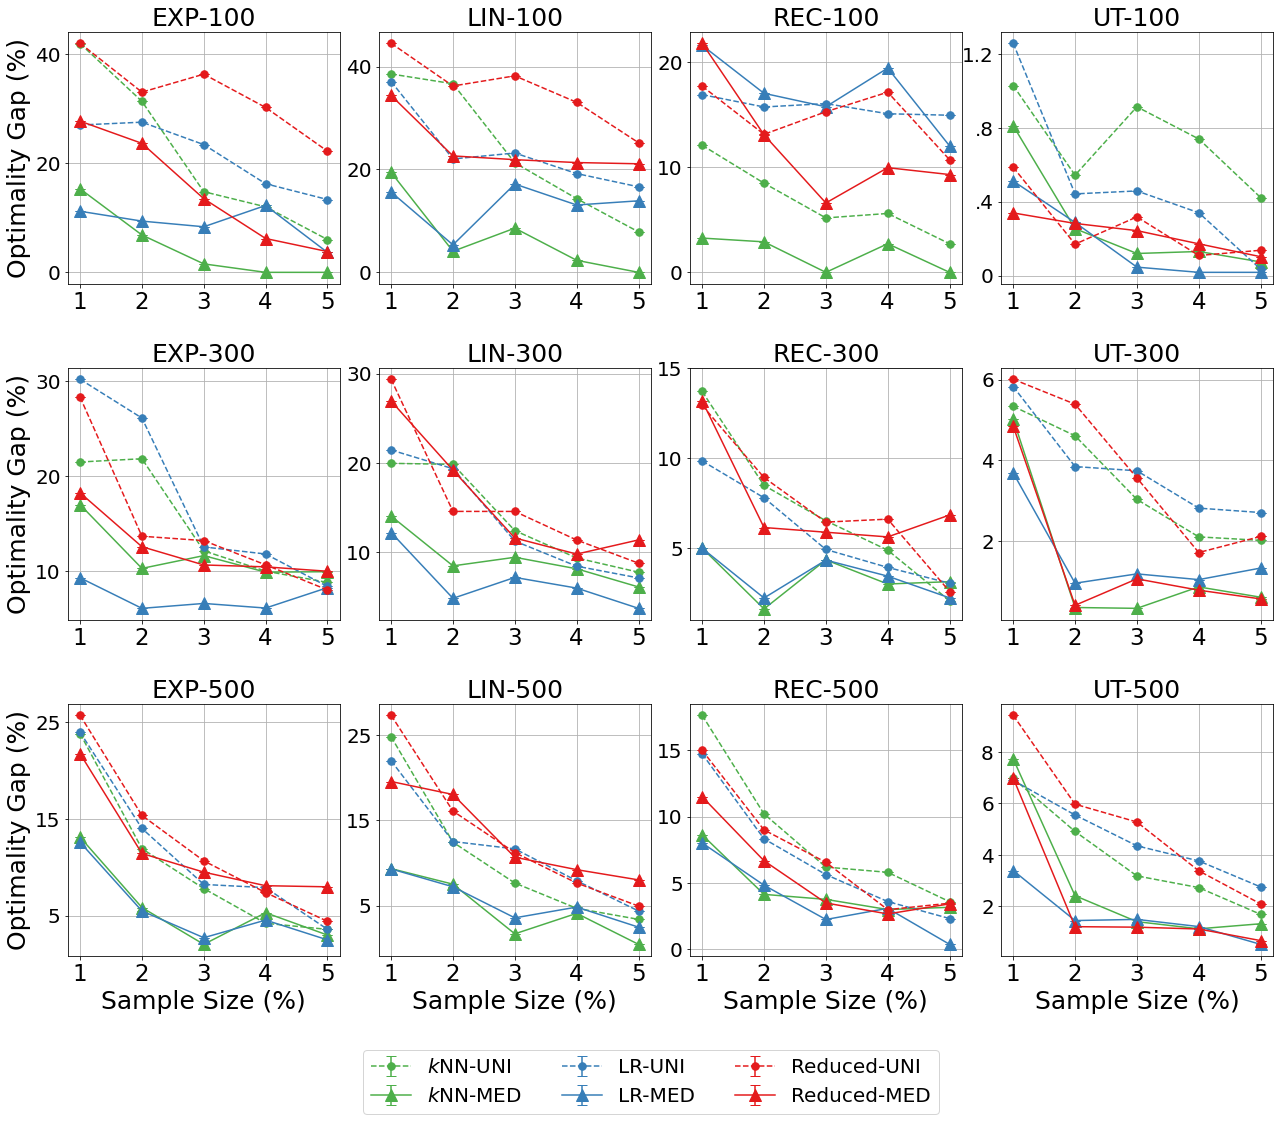

In [12]:
# create the figure
fig  = plt.figure(figsize=(18, 14))
ax11 = fig.add_axes([0.05, 0.2/3 + 2/3, 0.21, 0.25])
ax12 = fig.add_axes([0.29, 0.2/3 + 2/3, 0.21, 0.25])
ax13 = fig.add_axes([0.53, 0.2/3 + 2/3, 0.21, 0.25])
ax14 = fig.add_axes([0.77, 0.2/3 + 2/3, 0.21, 0.25])

ax21 = fig.add_axes([0.05, 0.2/3 + 1/3, 0.21, 0.25])
ax22 = fig.add_axes([0.29, 0.2/3 + 1/3, 0.21, 0.25])
ax23 = fig.add_axes([0.53, 0.2/3 + 1/3, 0.21, 0.25])
ax24 = fig.add_axes([0.77, 0.2/3 + 1/3, 0.21, 0.25])

ax31 = fig.add_axes([0.05, 0.2/3, 0.21, 0.25])
ax32 = fig.add_axes([0.29, 0.2/3, 0.21, 0.25])
ax33 = fig.add_axes([0.53, 0.2/3, 0.21, 0.25])
ax34 = fig.add_axes([0.77, 0.2/3, 0.21, 0.25])


ax = [[ax11, ax12, ax13, ax14],
      [ax21, ax22, ax23, ax24],
      [ax31, ax32, ax33, ax34]]

# set params
linestyle = {('knn', 'pmedian'): 'solid', ('reg', 'pmedian'): 'solid', ('naive', 'pmedian'): 'solid',
             ('knn', 'uniform'): 'dashed', ('reg', 'uniform'): 'dashed', ('naive', 'uniform'): 'dashed',
            ('naive', 'pcenter'): 'dashed', ('knn', 'pcenter'): 'dashed', ('reg', 'pcenter'): 'dashed', ('naive', 'pcenter'): 'dashed'}
colors = {'knn': '#4daf4a', 'reg': '#377eb8', 'naive': '#e41a1c'}
marker = {'pmedian': '^', 'uniform': '.', 'pcenter': 's'}
markersize = {'^': 12, 's': 8, '.': 15}
budgets=[100, 300, 500]
v_types = ['exp', 'linear', 'rec', 'utility']
titles = ['EXP', 'LIN', 'REC', 'UT']

f_l = {'learning': 'REP', 'tsp': 'TSP'}
s_l = {'pmedian': 'MED', 'uniform': 'UNI', 'pcenter': 'CEN'}
m_l = {'knn': '$k$NN', 'reg': 'LR', 'naive': 'Reduced'}

gaps = {'uniform': {'knn': [], 'reg': [], 'naive': []}, 'pmedian': {'knn': [], 'reg': [], 'naive': []}}

# here we go
for idx, v_type in enumerate(v_types):
    records = get_records(variant_type=v_type)
    for sol, sol_record in records[100].items():
        for sam, sam_record in sol_record.items():
            if (sol, sam) not in {('naive', 'uniform'), 
                                  ('naive', 'pmedian'),
                                  ('knn', 'uniform'), 
                                  ('reg', 'uniform'),
                                  ('knn', 'pmedian'), 
                                  ('reg', 'pmedian')}:
                continue
            
            for j, budget in enumerate([100, 300, 500]):
                val, err, sizes = [], [], []
                for size, size_record in sam_record.items():
                    val.append(np.mean(np.mean(records[budget][sol][sam][size])) * 100)
                    sizes.append(size * 100)
                    err.append(np.std(records[budget][sol][sam][size]) * 100)
                err = 0
                gaps[sam][sol].append(val)
                ax[j][idx].errorbar(sizes, val, yerr=err,
                                     marker=marker[sam], 
                                     capsize=5,
                                     color=colors[sol], 
                                     markersize=markersize[marker[sam]],
                                     label = '{}-{}'.format(m_l[sol], s_l[sam]),
                                     linestyle=linestyle[(sol, sam)])
                ax[j][idx].grid(visible=True)
                ax[j][idx].set_xticks(np.arange(1, 6, 1), [1, 2, 3, 4, 5], size=23)
                if j == 2:
                    ax[j][idx].set_xlabel('Sample Size (%)', size=25) 
                if idx == 0:
                    ax[j][idx].set_ylabel('Optimality Gap (%)', size=25) 
                ax[j][idx].set_title('{}-{}'.format(titles[idx], budget), size=25)

lines_labels = [ax[0][1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lgd = fig.legend(lines, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), prop={'size': 20})


ax[0][0].set_yticks([0, 20, 40], [0, 20, 40], size=20)
ax[1][0].set_yticks([10, 20, 30], [10, 20, 30], size=20)
ax[2][0].set_yticks([5, 15, 25], [5, 15, 25], size=20)

ax[0][1].set_yticks([0, 20, 40], [0, 20, 40], size=20)
ax[1][1].set_yticks([10, 20, 30], [10, 20, 30], size=20)
ax[2][1].set_yticks([5, 15, 25], [5, 15, 25], size=20)

ax[0][2].set_yticks([0, 10, 20], [0, 10, 20], size=20)
ax[1][2].set_yticks([5, 10, 15], [5, 10, 15], size=20)
ax[2][2].set_yticks([0, 5, 10, 15], [0, 5, 10, 15], size=20)

ax[0][3].set_yticks([0, 0.4, 0.8, 1.2], ['0', '.4', '.8', '1.2'], size=20)
ax[1][3].set_yticks([2, 4, 6], [2, 4, 6], size=20)
ax[2][3].set_yticks([2, 4, 6, 8], [2, 4, 6, 8], size=20)


# plt.savefig('figures/OptGapFull.png', dpi=300,  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


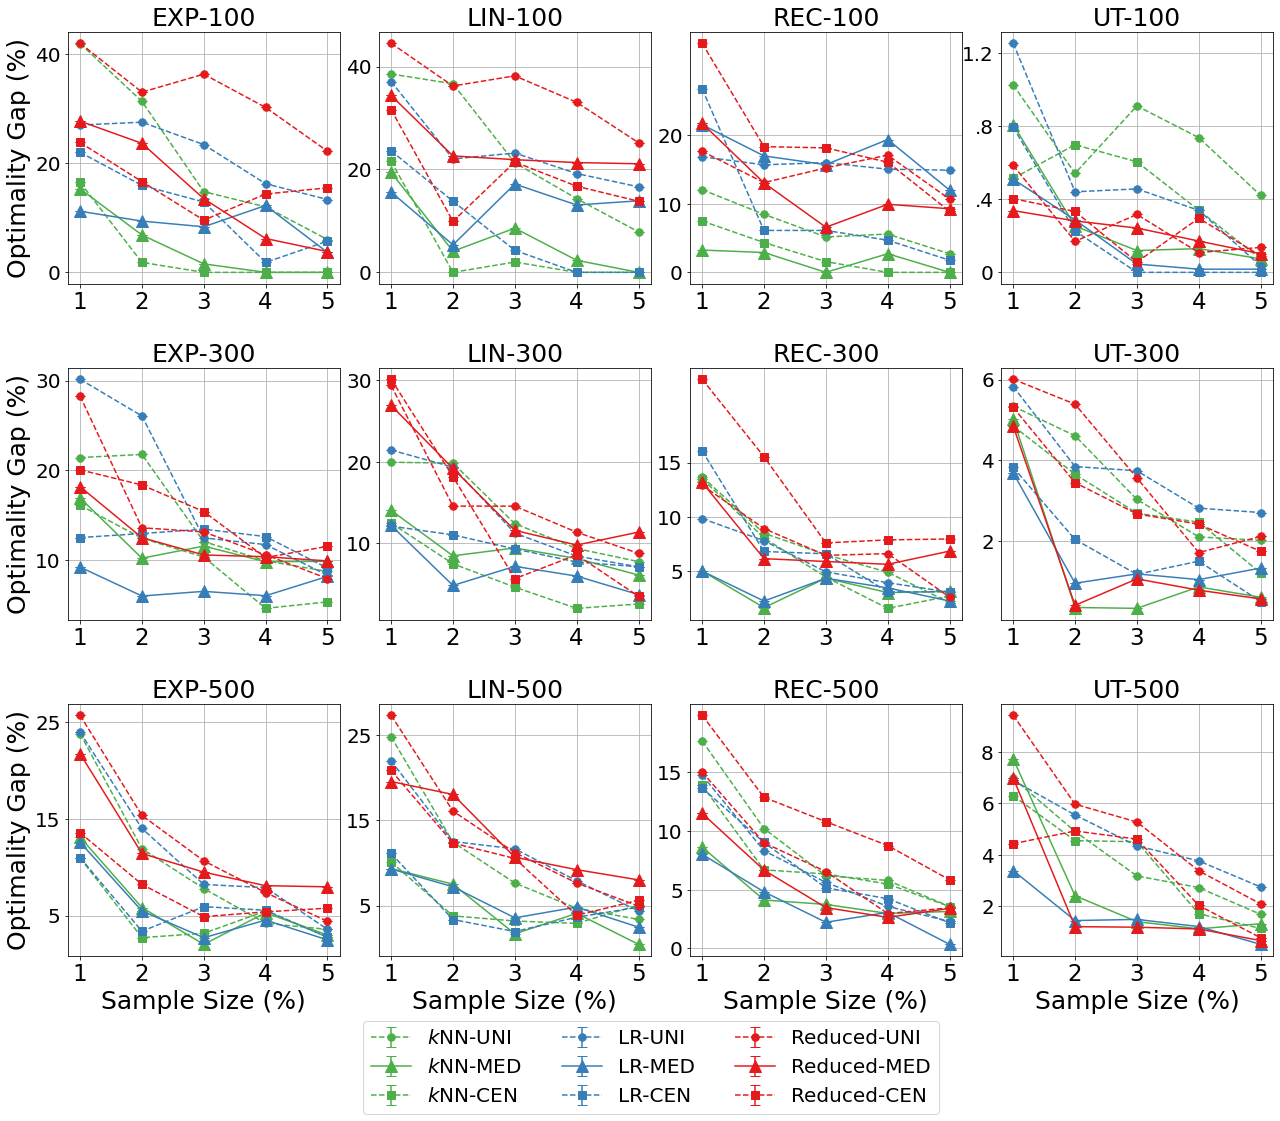

In [6]:
# create the figure
fig  = plt.figure(figsize=(18, 14))
ax11 = fig.add_axes([0.05, 0.2/3 + 2/3, 0.21, 0.25])
ax12 = fig.add_axes([0.29, 0.2/3 + 2/3, 0.21, 0.25])
ax13 = fig.add_axes([0.53, 0.2/3 + 2/3, 0.21, 0.25])
ax14 = fig.add_axes([0.77, 0.2/3 + 2/3, 0.21, 0.25])

ax21 = fig.add_axes([0.05, 0.2/3 + 1/3, 0.21, 0.25])
ax22 = fig.add_axes([0.29, 0.2/3 + 1/3, 0.21, 0.25])
ax23 = fig.add_axes([0.53, 0.2/3 + 1/3, 0.21, 0.25])
ax24 = fig.add_axes([0.77, 0.2/3 + 1/3, 0.21, 0.25])

ax31 = fig.add_axes([0.05, 0.2/3, 0.21, 0.25])
ax32 = fig.add_axes([0.29, 0.2/3, 0.21, 0.25])
ax33 = fig.add_axes([0.53, 0.2/3, 0.21, 0.25])
ax34 = fig.add_axes([0.77, 0.2/3, 0.21, 0.25])


ax = [[ax11, ax12, ax13, ax14],
      [ax21, ax22, ax23, ax24],
      [ax31, ax32, ax33, ax34]]

# set params
linestyle = {('knn', 'pmedian'): 'solid', ('reg', 'pmedian'): 'solid', ('naive', 'pmedian'): 'solid',
             ('knn', 'uniform'): 'dashed', ('reg', 'uniform'): 'dashed', ('naive', 'uniform'): 'dashed',
            ('naive', 'pcenter'): 'dashed', ('knn', 'pcenter'): 'dashed', ('reg', 'pcenter'): 'dashed', ('naive', 'pcenter'): 'dashed'}
colors = {'knn': '#4daf4a', 'reg': '#377eb8', 'naive': '#e41a1c'}
marker = {'pmedian': '^', 'uniform': '.', 'pcenter': 's'}
markersize = {'^': 12, 's': 8, '.': 15}
budgets=[100, 300, 500]
v_types = ['exp', 'linear', 'rec', 'utility']
titles = ['EXP', 'LIN', 'REC', 'UT']

f_l = {'learning': 'REP', 'tsp': 'TSP'}
s_l = {'pmedian': 'MED', 'uniform': 'UNI', 'pcenter': 'CEN'}
m_l = {'knn': '$k$NN', 'reg': 'LR', 'naive': 'Reduced'}

# here we go
for idx, v_type in enumerate(v_types):
    records = get_records(variant_type=v_type)
    for sol, sol_record in records[100].items():
        for sam, sam_record in sol_record.items():
            if (sol, sam) not in {
                                  ('naive', 'uniform'), 
                                  ('naive', 'pmedian'),
                                  ('naive', 'pcenter'),
                                  ('knn', 'uniform'), 
                                  ('reg', 'uniform'),
                                  ('knn', 'pmedian'), 
                                  ('reg', 'pmedian'),
                                  ('knn', 'pcenter'), 
                                  ('reg', 'pcenter')}:
                continue
            for j, budget in enumerate([100, 300, 500]):
                
                val, err, sizes = [], [], []
                for size, size_record in sam_record.items():
                    val.append(np.mean(np.mean(records[budget][sol][sam][size])) * 100)
                    sizes.append(size * 100)
                    err.append(np.std(records[budget][sol][sam][size]) * 100)
                err = 0
                ax[j][idx].errorbar(sizes, val, yerr=err,
                                     marker=marker[sam], 
                                     capsize=5,
                                     color=colors[sol], 
                                     markersize=markersize[marker[sam]],
                                     label = '{}-{}'.format(m_l[sol], s_l[sam]),
                                     linestyle=linestyle[(sol, sam)])
                ax[j][idx].grid(visible=True)
                ax[j][idx].set_xticks(np.arange(1, 6, 1), [1, 2, 3, 4, 5], size=23)
                if j == 2:
                    ax[j][idx].set_xlabel('Sample Size (%)', size=25) 
                if idx == 0:
                    ax[j][idx].set_ylabel('Optimality Gap (%)', size=25) 
                ax[j][idx].set_title('{}-{}'.format(titles[idx], budget), size=25)

            
lines_labels = [ax[0][1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# lines = [lines[0], lines[1], lines[6], lines[2], lines[3], lines[7], lines[4], lines[5], lines[8]]
# labels = [labels[0], labels[1], labels[6], labels[2], labels[3], labels[7], labels[4], labels[5], labels[8]]
lgd = fig.legend(lines, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), prop={'size': 20})


ax[0][0].set_yticks([0, 20, 40], [0, 20, 40], size=20)
ax[1][0].set_yticks([10, 20, 30], [10, 20, 30], size=20)
ax[2][0].set_yticks([5, 15, 25], [5, 15, 25], size=20)

ax[0][1].set_yticks([0, 20, 40], [0, 20, 40], size=20)
ax[1][1].set_yticks([10, 20, 30], [10, 20, 30], size=20)
ax[2][1].set_yticks([5, 15, 25], [5, 15, 25], size=20)

ax[0][2].set_yticks([0, 10, 20], [0, 10, 20], size=20)
ax[1][2].set_yticks([5, 10, 15], [5, 10, 15], size=20)
ax[2][2].set_yticks([0, 5, 10, 15], [0, 5, 10, 15], size=20)

ax[0][3].set_yticks([0, 0.4, 0.8, 1.2], ['0', '.4', '.8', '1.2'], size=20)
ax[1][3].set_yticks([2, 4, 6], [2, 4, 6], size=20)
ax[2][3].set_yticks([2, 4, 6, 8], [2, 4, 6, 8], size=20)


plt.savefig('figures/OptGap_UNIMEDCEN.png', dpi=300,  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Stability Analysis

In [229]:
records = get_records(variant_type='linear')

sol, sam = 'naive', 'uniform'
x_err = []
for idx, budget in enumerate(budgets):
    for size in [0.01, 0.02, 0.03, 0.04, 0.05]:
        x_err.append(np.std(records[budget][sol][sam][size]) * 100)

sol, sam = 'knn', 'pmedian'
y_err = []
for idx, budget in enumerate(budgets):
    for size in [0.01, 0.02, 0.03, 0.04, 0.05]:
        y_err.append(np.std(records[budget][sol][sam][size]) * 100)

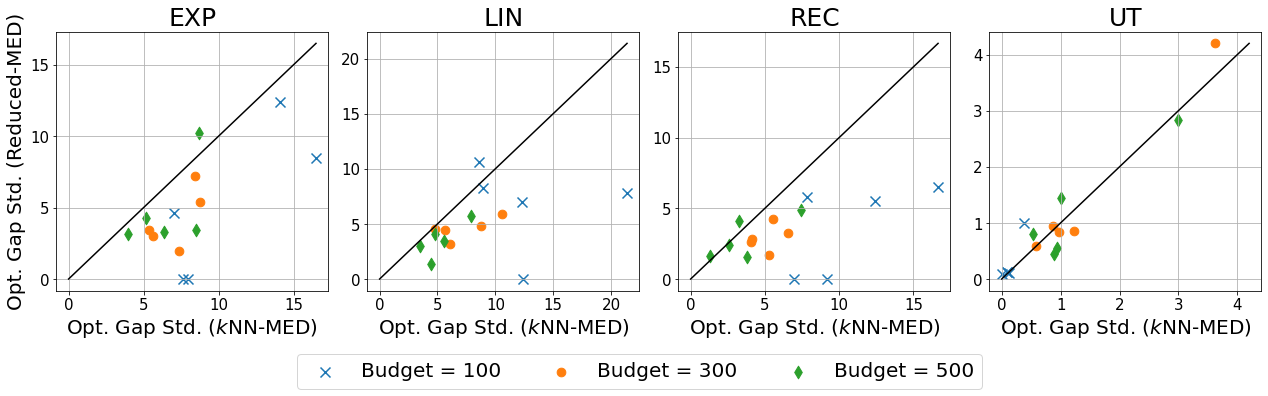

In [17]:
fig  = plt.figure(figsize=(18, 6))
ax1 = fig.add_axes([0.05, 0.2, 0.21, 0.6])
ax2 = fig.add_axes([0.29, 0.2, 0.21, 0.6])
ax3 = fig.add_axes([0.53, 0.2, 0.21, 0.6])
ax4 = fig.add_axes([0.77, 0.2, 0.21, 0.6])
ax = [ax1, ax2, ax3, ax4]

x_sam, x_sol, y_sam, y_sol = 'pmedian', 'naive', 'pmedian', 'knn'
titles = ['EXP', 'LIN', 'REC', 'UT']
colors = {'utility': '#e41a1c', 'exp': '#377eb8', 'linear': '#4daf4a', 'rec': '#984ea3'}
marker = {100: 'x', 300: '.', 500: 'd'}
markersize = {'x': 100, '.': 300, 'd': 80}


for idx, v_type in enumerate(['exp', 'linear', 'rec', 'utility']):
    ax[idx].set_title(titles[idx], size=25)
#     if idx == 0:
#         continue
    records = get_records(variant_type=v_type)
    max_bd = 0
    for budget in [100, 300, 500]:
        x_err, y_err = [], []
        for size in [0.01, 0.02, 0.03, 0.04, 0.05]:
            x_err.append(np.std(records[budget][x_sol][x_sam][size]) * 100)
            y_err.append(np.std(records[budget][y_sol][y_sam][size]) * 100)
        max_bd = np.max(x_err + y_err + [max_bd])
        ax[idx].scatter(x_err, y_err, 
                        marker=marker[budget], 
                        s=markersize[marker[budget]],
                        label='Budget = {}'.format(budget))
    ax[idx].plot([0, max_bd], [0, max_bd], color='black')
    ax[idx].set_xlabel('Opt. Gap Std. ($k$NN-MED)', size=20)
    if idx == 0:
        ax[idx].set_ylabel('Opt. Gap Std. (Reduced-MED)', size=20)
#     ax[idx].set_xticks([])
#     ax[idx].set_yticks([])
    ax[idx].grid(True)

ax[0].set_xticks([0, 5, 10, 15], [0, 5, 10, 15], size=15)
ax[0].set_yticks([0, 5, 10, 15], [0, 5, 10, 15], size=15)

ax[1].set_xticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20], size=15)
ax[1].set_yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20], size=15)

ax[2].set_xticks([0, 5, 10, 15], [0, 5, 10, 15], size=15)
ax[2].set_yticks([0, 5, 10, 15], [0, 5, 10, 15], size=15)

ax[3].set_xticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], size=15)
ax[3].set_yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4], size=15)
    
lines_labels = [ax[1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
lgd = fig.legend(lines, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), prop={'size': 20})

plt.savefig('figures/StdOptGapRedKnn_MED.png', dpi=300,  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()